## Processing EB imaging data
Note that here we use a max projection across z-planes instead of analyzing 4D imaging data.

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr

import pandas as pd

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
from fly2p.viz.viz import myAxisTheme, plotShapelyLine, plotEllipse
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

#### Set paths to data files and plot directory

In [48]:
rootDir = '../../../../data_unityvr'
dataDir = sep.join([rootDir, 'raw/EPG/SS96_x_7f/f01'])
rawTiff = 'SS96-x-7f_f01_3-5d_EB_2LM_00002.tif'
plotDir = sep.join([rootDir, 'plot', sep.join(dataDir.split(sep)[-3:])])

print(dataDir)
print(plotDir)

genotype = rawTiff.split('_')[0]
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = 'trial'+rawTiff.split('_')[-1][:-4][-2:]
print(genotype, region, flyID, age, condition, trial)

../../../../data_unityvr/raw/EPG/SS96_x_7f/f01
../../../../data_unityvr/plot/EPG/SS96_x_7f/f01
SS96-x-7f EB f01 3-5d 2LM trial02


In [49]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,genotype, condition])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

../../../../data_unityvr/plot/EPG/SS96_x_7f/f01/SS96-x-7f/2LM


#### Load data and perform motion correction

In [50]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())
#basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


In [51]:
stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

Check if reference image is good: It should not be to biased by transient activity peaks.

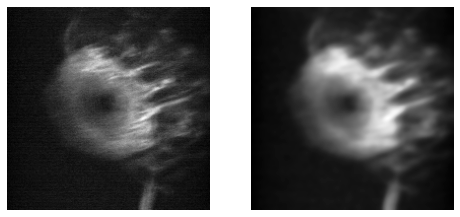

In [52]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

In [53]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

#### Compute DFF

In [54]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

In [55]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)

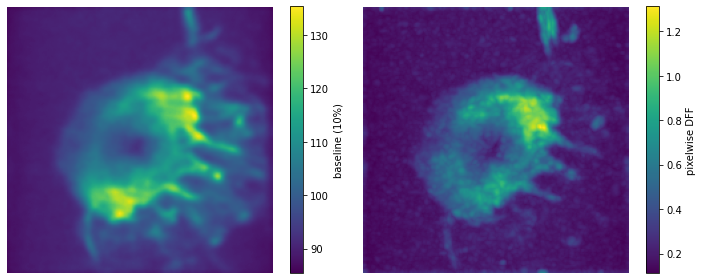

In [56]:
dffMP = np.max(dffStack,axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)

### Generate ROIs automatically
We will do this here only for pixels within a manually drawn mask, but it also works fine without a mask.

In [57]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)

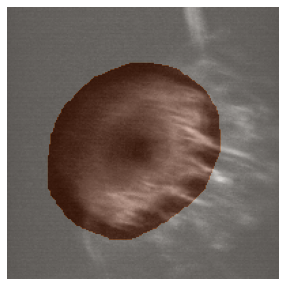

In [58]:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

In [59]:
# Settings
from sklearn.cluster import KMeans

nclst = 9 # 8 + 1 or 2

toClust = dffStack[:,mask.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [60]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = dffXarray.coords['volumes [s]'].values

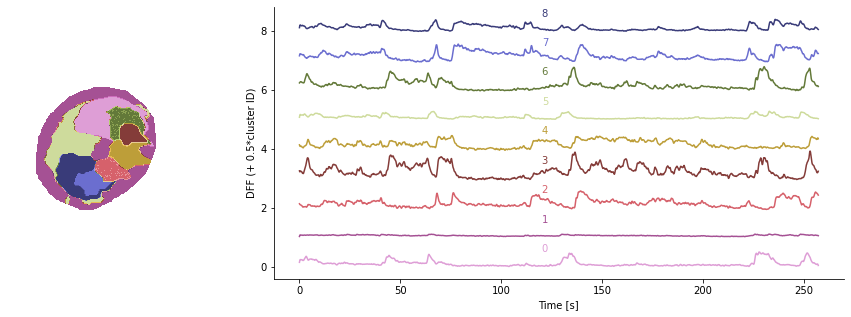

In [61]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

In [66]:
time.shape

(1400,)

In [65]:
centroids2Plot.shape

(9, 1400)

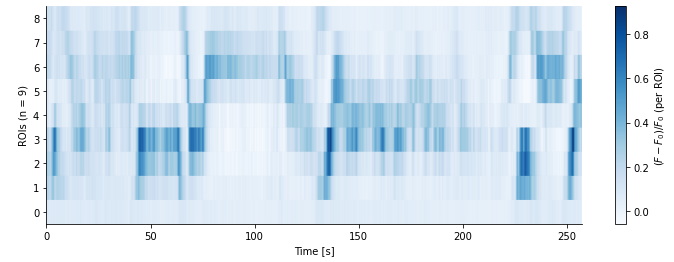

In [62]:
centroidPerm = [1,0,6,3,4,2,7,8,5]
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))
cax = axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face', shading='nearest')
axs.set_xlabel('Time [s]')
axs.set_ylabel('\nROIs (n = {0})'.format(nclst))
myAxisTheme(axs)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar
fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

#### Generate data object and save to disk

In [63]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

roiDf = pd.DataFrame(data = centroids2Plot.T, 
                     columns = ['background'] + ['wedge{}'.format(i+1) for i in range(8)])
roiDf['time [s]']  = time

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat, expMetadata = expMetadata,
    refImage = refImg, refStackMC = np.mean(stackMPMC,axis=0), dffStack = np.max(dffXarray,axis=0), 
    roitype = "corr",roiMask = kmlabsImg, roiDFF = roiDf
)

preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-3:])])
# Generate directory where to save plots
ppsaveDir = sep.join([preprocDir, condition])
imgTS_corrroi.saveData(ppsaveDir, trial)

'../../../../data_unityvr/preproc/EPG/SS96_x_7f/f01/2LM/trial02/img'


#

### Generate ROIs using shapely
Open registered image stack or reference image in napari and draw roi guides

#### Draw guide lines for EB roi segmentation
* mark the center of the EB (dot) -> name "EBctr"
* draw two lines marking the axes of the ellipse (line forms) -> name "EBlax" and "EBsax"

In [21]:
viewer = napari.view_image(refImgFilt)

In [22]:
ebcenter = viewer.layers["EBctr"].data[0]
eblongax = viewer.layers["EBlax"].data[0]
ebshortax = viewer.layers["EBsax"].data[0]

#### Generate shapely-objects to represent ROIs

In [23]:
EBaxisL = LineString(eblongax)
EBaxisS = LineString(ebshortax)

In [24]:
ellipseCntr = ebcenter #EBroiRing.centroid.coords[0]
print('EB center coordinates (px): {0}'.format(ellipseCntr))

print('EB axis lengths:  axis 1 = {0}, axis 2 = {1}'.format(round(EBaxisL.length/2.), round(EBaxisS.length/2.)))

axvec = abs(np.asarray(EBaxisL.coords[0])-np.asarray(EBaxisL.coords[1]))
ellipseRot = 90-np.arctan(axvec[0]/axvec[1])*180/np.pi
print('EB main axis rotation (deg): {0}'.format(round(ellipseRot)))

EB center coordinates (px): [101.72023546  92.12020693]
EB axis lengths:  axis 1 = 61, axis 2 = 50
EB main axis rotation (deg): 37


In [25]:
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = (ellipseCntr,(EBaxisL.length/2., EBaxisS.length/2.),ellipseRot)

# Let create a circle of radius 1 around center point:
circ = sp.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = sp.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (counterclockwise, x axis pointing right):
ell = sp.affinity.rotate(ell,-ellipse[2])
# According to the man, a positive value means a anti-clockwise angle,
# and a negative one a clockwise angle.

EBoutline = ell.exterior

In [34]:
# Find points on EB outline
nsteps = 8
EBroiPts = [ellipseCntr]

for s in range(nsteps):
    [sx,sy] = EBoutline.interpolate(s/nsteps, normalized=True).coords.xy
    EBroiPts.append((sx[0],sy[0]))
    
# Shift ROI pts circularely to start at ventral part of EB
st = 1
EBroiPtsCopy = EBroiPts.copy()

for s in range(1,nsteps+1):
    EBroiPts[s] = EBroiPtsCopy[(s+st)%nsteps+1]

In [35]:
EBroiPolys = []
for s in range(nsteps):
    if s+1==nsteps:
        EBroiPolys.append([EBroiPts[0],EBroiPts[s+1],EBroiPts[1]])
    else:
        EBroiPolys.append([EBroiPts[0],EBroiPts[s+1],EBroiPts[s+2]])

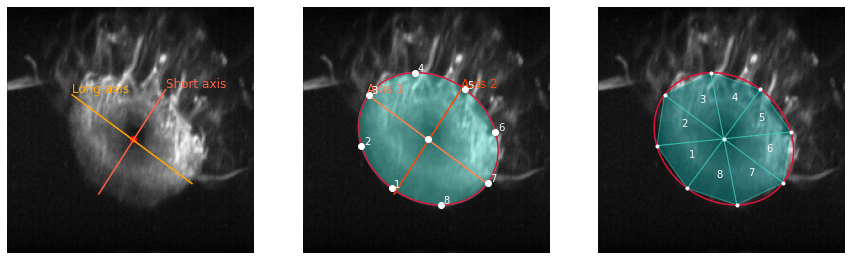

In [36]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

for ax in axs:
    ax.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='lower')
    ax.axis('off');

axs[0].plot(ebcenter[0],ebcenter[1], 'ro')
axs[0] = plotShapelyLine(axs[0], EBaxisL, 'Long axis', 'orange')
axs[0] = plotShapelyLine(axs[0], EBaxisS, 'Short axis', 'tomato')

axs[1] = plotEllipse(axs[1], ellipseCntr, EBaxisL.length, EBaxisS.length, ellipseRot,'turquoise', 0.4)
axs[1] = plotShapelyLine(axs[1], EBaxisL, 'Axis 1', 'coral')
axs[1] = plotShapelyLine(axs[1], EBaxisS, 'Axis 2', 'orangered')
axs[1] = plotShapelyLine(axs[1], EBoutline, '', 'crimson')

for s in range(nsteps):
    axs[1].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'wo')
    axs[1].text(EBroiPts[s+1][0]+2,EBroiPts[s+1][1]+1, str(s+1), color='w')
axs[1].plot(ellipseCntr[0],ellipseCntr[1],'wo')

axs[2].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='crimson')
for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.5, edgecolor='turquoise', facecolor='teal')
    axs[2].add_patch(roiPatch)
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs[2].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')
    axs[2].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
axs[2].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
fig.savefig(saveDir+sep+'_'.join(['polyRoiConstruction',genotype, region, flyID, age, condition, trial])+'.pdf')

In [37]:
# create a list of possible pixel coordinates
imgrid = np.meshgrid(np.arange(0,stackMPMC['xpix [µm]'].size), np.arange(0,stackMPMC['ypix [µm]'].size))
pxcoords = list(zip(*(c.flat for c in imgrid)))

# Get all points in EB ellipse
EBPatch = ppatch.Polygon(EBroiPts[1:])
roiPts_x = [p[0] for p in pxcoords if EBPatch.contains_point(p, radius=0)]
roiPts_y = [p[1] for p in pxcoords if EBPatch.contains_point(p, radius=0)]

EBCoords = np.vstack((roiPts_x,roiPts_y))

# List for all roi point lists
EBroiCoords = []

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s])

    # create the list of valid coordinates (from untransformed)
    roiPts_x = [p[0] for p in pxcoords if roiPatch.contains_point(p, radius=0)]
    roiPts_y = [p[1] for p in pxcoords if roiPatch.contains_point(p, radius=0)]
    EBroiCoords.append(np.vstack((np.asarray(roiPts_x),np.asarray(roiPts_y))))

In [38]:
dffROI = np.zeros((nsteps,dffStack.shape[0]))

for s in range(nsteps):
    dffROI[s,:] = dffStack[:,EBroiCoords[s][0],EBroiCoords[s][1]].mean(1)
time = dffXarray.coords['volumes [s]'].values

<ipython-input-46-252bf4d87a9c>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = axs[1].pcolor(time,np.arange(0,nsteps+1),dffROI,cmap='Blues', edgecolors='face',shading='auto')


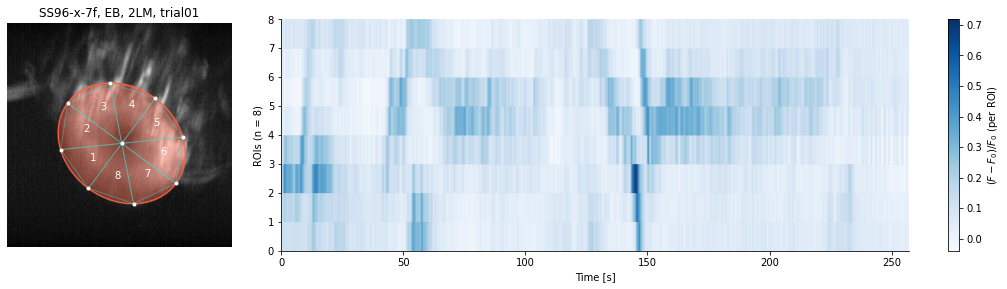

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,4),gridspec_kw={'width_ratios':[1,3.5]})

axs[0].imshow(np.mean(stackMP,axis=0).T,cmap='Greys_r', origin='lower')#, vmin=0, vmax=0.7*np.max(stackMP))

patch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')

axs[0].add_patch(patch)
axs[0].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='tomato', linewidth=1)

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.4, edgecolor='turquoise', facecolor='none')
    axs[0].add_patch(roiPatch)
    axs[0].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs[0].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')

axs[0].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
axs[0].axis('off')
axs[0].set_title(', '.join([genotype, region, condition, trial]))

#cax = axs[1].imshow(EBtraces,cmap='Blues', aspect=20, interpolation='None', origin='lower', vmin=0)
cax = axs[1].pcolor(time,np.arange(0,nsteps+1),dffROI,cmap='Blues', edgecolors='face',shading='auto')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('\nROIs (n = {0})'.format(nsteps))
myAxisTheme(axs[1])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar

fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['roiMap-dFFtimeseries',genotype, region, flyID, age, condition, trial])+'.pdf')

#### Generate data object and save to file

In [47]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "poly",
    'brainregion': region
}

roiDf = pd.DataFrame(data = centroids2Plot.T, 
                     columns = ['background'] + ['wedge{}'.format(i+1) for i in range(8)])
roiDf['time [s]']  = time

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat, expMetadata = expMetadata,
    refImage = refImg, refStackMC = np.mean(stackMPMC,axis=0), dffStack = np.max(dffXarray,axis=0), 
    roitype = "corr",roiMask = kmlabsImg, roiDFF = roiDf
)

preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-3:])])
# Generate directory where to save plots
ppsaveDir = sep.join([preprocDir, condition])
imgTS_corrroi.saveData(ppsaveDir, trial)

'../../../../data_unityvr/preproc/EPG/SS96_x_7f/f01/2LM/trial01/img'

#### Compute PVA

In [ ]:
def computePVA (locs, weights):
    """ Compute population vector average
    """
    nsteps = weights.shape[0]
    nvol = weights.shape[1]
    pva_x = np.cos(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    pva_y = np.sin(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    
    pva = np.vstack((sum(pva_x)/len(pva_x), sum(pva_y)/len(pva_x)))
    return pva

In [ ]:
roiArcPos = np.linspace(0, 2*np.pi, nsteps+1)[:-1]

pva = computePVA(roiArcPos,EBtracesFilt)
pvaRad = np.arctan2(pva[1,:],pva[0,:])
pvaLen = np.hypot(pva[0,:],pva[1,:])

PVAst = 3#7.5
pvaRoi = np.mod((np.unwrap(pvaRad,np.pi) - pvaRad[0]) * nsteps/(2*np.pi) + PVAst, nsteps)

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(12,8),gridspec_kw={'height_ratios':[1,0.5, 1, 0.5]})
cax = axs[0].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')
axs[0].set_ylabel('\nROIs (n = {0})\nPVA in blue'.format(nsteps))
axs[0].plot(time,pvaRoi,'-', color='midnightblue', linewidth=1, alpha=0.5)


axs[1].plot(time,EBdFF,color='midnightblue')
axs[1].set_ylabel('Average dFF\nin whole EB')

axs[2].plot(time,pvaRad,color='steelblue')
axs[2].set_ylabel('PVA direction [rad]')
axs[3].plot(time,pvaLen,color='dimgrey')
axs[3].set_ylabel('PVA length')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(time[0],time[-1])
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['dFFandPVA',genotype, region, flyID, age, condition, trial, date])+'.pdf')